In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

# Processing tabula muris demo dataset

## First, read in all the data

In [2]:
## Read in each tissue-specific matrix and concatenate them
counts = [pd.read_csv(file, index_col=0).T for file in glob('../data/tabula-muris/FACS/*counts.csv')]
counts = pd.concat(counts)

In [3]:
## Load the metadata
annotations = pd.read_csv('/Users/sidneybell/Desktop/tmuris/annotations_facs.csv', index_col='cell')

## Pull the annotation fields we want
annotation_fields = ['cell_ontology_class', 'cluster.ids', 'free_annotation', 'mouse.sex', 'mouse.id', 
                     'plate.barcode', 'tissue', 'subtissue']
annotations = annotations[annotation_fields]

/Users/sidneybell/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Normalize the values per the methods specified in the paper  

In [6]:
# 1. Cells were lexicographically sorted by cell ID to ensure reproducibility. 
counts.sort_index(inplace=True)

In [8]:
## Wrangle into an anndata object
adata = sc.AnnData(X=counts)
adata.obs = adata.obs.join(annotations[annotation_fields])
adata.obs['cluster.ids'] = adata.obs['cluster.ids'].astype('str')

In [9]:
'''2. Cells with fewer than 500 detected genes were excluded. 
(A gene counts as detected if it has at least one read mapping to it).'''
sc.pp.filter_cells(adata, min_genes=500)

'''Cells with fewer than 50,000 reads (FACS) or 1000 UMI (microfluidic droplet) were excluded.'''
sc.pp.filter_cells(adata, min_counts=50000)


'''3. Counts were log-normalized for each cell using the natural logarithm of 1 + counts per million (for FACS)'''
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1000000) # counts per million
sc.pp.log1p(adata) # ln

'''4. Variable genes were selected using a threshold (0.5) for the standardized log dispersion, 
where the standardization was done in separately according to binned values of log mean expression.
'''
sc.pp.filter_genes_dispersion(adata, log=False, flavor='seurat', min_disp=0.5)

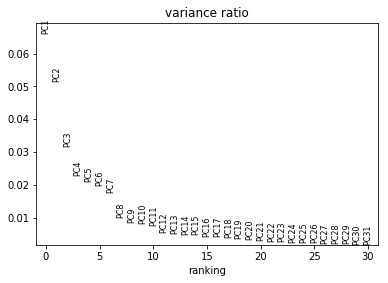

In [13]:
'''5. The variable genes were projected onto a low-dimensional subspace using principal component analysis. 
The number of principal components was selected based on inspection of the plot of variance explained.
'''
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [14]:
'''A shared-nearest-neighbors graph was constructed based on the Euclidean
distance in the low-dimensional subspace spanned by the top principal
components. '''
sc.pp.neighbors(adata, n_pcs=7, metric='euclidean', use_rep='X_pca') 
## number of components not reported in the paper, but this looks like a reasonable choice

## Compute several low-dimensional embeddings for visualization

In [17]:
sc.tl.tsne(adata, perplexity=30, n_pcs = 7, use_rep='X_pca')

sc.tl.umap(adata)
sc.tl.draw_graph(adata)

## Assign clusters with two different methods

In [18]:
sc.tl.louvain(adata)
sc.tl.leiden(adata)

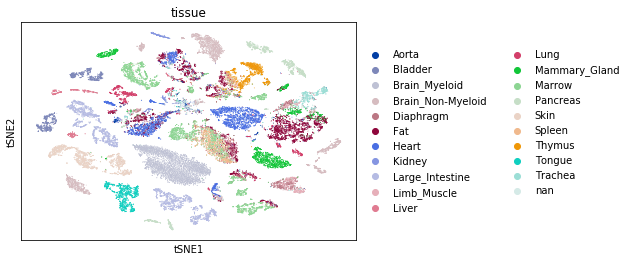

In [19]:
sc.pl.tsne(adata, color='tissue')

In [22]:
adata.obs.rename(columns={'cluster.ids': 'clusters_from_manuscript',
                          'mouse.sex': 'mouse_sex', 
                          'mouse.id': 'mouse_id', 
                          'plate.barcode': 'plate_barcode', 
                          'louvain': 'clusters_louvain', 
                          'leiden': 'clusters_leiden'}, inplace=True)

In [23]:
adata.write('./tabula-muris.h5ad')